## Machine Learning project - Meta

#### Data generation

A given dataset 'D' is made of a vector 'y' containing the independent variable and a matrix 'x' of dependent variables for it. D = y+x.

In our case, we must distinguish 'fake' datasets 'fD', used to test our dependent variables on actual hyperparameters, and our 'real' dataset 'rD' on which our model will run. rD is derived from sets of fDs. 

To generate an fD = y+x we:
1. build the vector 'y' using 'get_y()'
2. build a matrix 'x' using 'get_x()'

To generate an rD = ry+xy we:

1. build a fake dataset fD using 'gen_dataset()' (that relies on the above)
2. get the hyperparameter value for that dataset using 'get_hp()'
3. get the dependent variables for that dataset using 'get_dv()'
4. repeat for each line of rD

Steps (1-2) are only there to confirm the impact of our dependent variables on the choice of hyperparameter. It will eventually be replaced with simple generation formulas based on our assumptions and observations.

The function 'w()' lets us save our generated data as a 'csv'. We don't use 'np.savetxt()' or 'np.to_csv()' so that we can easily append. Conversely, 'w()' adds a header that should be removed if imported directly into numpy.

In [1]:
from typing import Literal
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as sk_kNN
from sklearn.metrics import accuracy_score as sk_acc
from sklearn.model_selection import train_test_split as sk_tts

## Utility functions
def w(data: np.array, f: str="metadb.csv", 
      mode: str='a', sep: str=',', ch_header: bool=True) -> None:
    """Writes/appends to a csv."""
    if not mode in ['w', 'a']:                  # invalid mode
        return
    if not os.path.isfile(f) or mode == 'w':    # renew header
        wf = open(f, 'w', encoding="utf-8")
        if ch_header:
            wf.write(sep.join([f"x{a}" if a > 0 else "y" 
                         for a in range(data.shape[1])])) # columns
        wf.close()
    with open(f, 'a', encoding="utf-8") as wf:  # actual writing
        for line in data:
            ltxt = [f"{d}" for d in line]
            wf.write("\n"+sep.join(ltxt))

## Fake datasets
def get_y(yc: int=3, ny: list=[100, 20]) -> np.array:
    """Generates an 'y' vector (fake dataset)."""
    ly = int(np.random.normal(ny[0], ny[1])) # nb of rows
    return np.random.choice([a for a in range(yc)], ly)
def get_x(y: np.array, nx: list=[3, 0], var: list=[50, 5]) -> np.array:
    """Generates an 'x' matrix for a given 'y' vector (fake dataset)."""
    lx = int(np.random.normal(nx[0], nx[1]))
    mx = np.random.randint(lx)
    x = [[np.random.normal(0, var[1])*(ry+1) if i != mx else 
          np.random.normal(var[0], var[1])*(ry+1) for i in range(lx)] 
         for ry in y]
    return np.array(x)
def gen_dataset(fy=None, fx=None, 
                argy: list=[3, [100, 20]],
                argx: list=[[3, 0], [50, 5]]) -> tuple:
    """Generates a fake dataset.
    Parameters:
    - fy/fx        functions to generate y/x respectively.
    - argy/argx    arguments for those functions, as lists.
    Note: 'fx' will always receive 'y' as first parameter."""
    fy, fx = get_y if not fy else fy, get_x if not fx else fx
    y = fy(*argy)
    return (y, fx(y, *argx))

## Hyperparameter / dependent variables
def get_hp(y: np.array, x: np.array) -> int:
    """Runs a kNN to find the best 'k'."""
    x_tr, x_te, y_tr, y_te = sk_tts(x, y) # train/test
    rk, ra, ly = 0, -1., int(len(y)/2)-1
    for k in np.arange(1, ly, 1):         # all possible k's
        m = sk_kNN(k)                     # kNN model
        m.fit(x_tr, y_tr)                 # fit on training data
        yp_te = m.predict(x_te)           # predict on test data
        a = sk_acc(y_te, yp_te)           # get accuracy score
        if a > ra:                        # pick best 'k'
            ra, rk = a, k
    return rk
def get_dv(y: np.array, x: np.array) -> np.array:
    """Gets dependent variables from our y/x dataset."""
    # add variables...
    rx = [len(y),                         # nb of rows
          len(np.unique(y)),              # nb of classes
          len(x[0]),                      # nb of dependent variables
    ]
    return np.array(rx)

## Main function
def simulate(n: int=1000, fy=None, fx=None, 
             argy: list=[3, [100, 20]],
             argx: list=[[3, 0], [50, 5]]) -> np.array:
    """Main function to generate 'n' datapoints for our model.
    Parameters:
    - n          number of fake datasets.
    - fx/fy      functions to generate y/x respectively (fake datasets)
    - argy/argx  arguments for those functions, as lists.
    Returns:
    - a numpy matrix with hyperparameter as first column 
                          and and dependent variables as the rest."""
    res = []                           # return value (matrix)
    for _ in range(n):
        y, x = gen_dataset(fy, fx, argy, argx) # fake dataset
        # s = time.time()
        ry = get_hp(y, x)              # hyperparameter
        # print("HP:", _, time.time()-s)
        rx = get_dv(y, x)              # dependent variables
        res.append([ry]+list(rx))
    return np.array(res)

#### Dataset length

As a rule of thumb, the more data we have the higher the hyperparameter 'k'. The rule of thumb is $\sqrt{N}/2$ where N is the number of datapoints. 

We can verify this (below) by simulating datasets of length 100 and 1000 respectively. Testing the variance is pointless as, eventually, we get the same average. 
* For 100 datapoints, we get k ~= 2 (rule of thumb ~5).
* For 1000 datapoints, we get k ~= 10 (rule of thumb ~15).
Note: getting the hyperparameter for 1000 datapoints, all else equal, takes ~14s. Testing for 10,000 datapoints would become prohibitive.

For simulation purposes we can assume that the rule of thumb stands. 

In [2]:
def test_len():
    """Temporary function to test hyperparameter variation, 
       here data length."""
    for i, ny in enumerate([[100, 5], [1000, 5], [100, 40], [1000, 100]]):
        s = time.time()
        a = simulate(10, argy=[3, ny])# ; w(a, mode="w" if i == 0 else "a")
        print(ny, np.mean(a[:, 0]), f"Time: {time.time()-s:.03f}")

#test_len()
"""[100, 5]    5.9  Time: 1.998
   [1000, 5]   13.2 Time: 144.840
   [100, 40]   1.7  Time: 2.284
   [1000, 100] 11.4 Time: 151.673"""

'[100, 5]    5.9  Time: 1.998\n   [1000, 5]   13.2 Time: 144.840\n   [100, 40]   1.7  Time: 2.284\n   [1000, 100] 11.4 Time: 151.673'

#### Dataset noise

The main reason to pick a higher 'k' is for noisy data. 

Changing the variance of 'x' doesn't seem to influence the result; the average normal distribution is too strong. Instead, the type of distribution has an impact:
* Random: no y ~ x relationship whatsoever
* Linear: y = ax
* Quadratic: y = ax^2
* Probabilistic: linear, but 'p' datapoints have no relationship

In general the formula used for simulation (where 'x' is defined as $a*y^i$ ) is likely wrong. That, however, might not matter. Output (the obtained 'k' hyperparameter) has a high variance and so the results should be read carefully as well as repeated.

We have yet to confirm a difference between 'linear' and 'quadratic', which again might be due to the formula used. We can confirm that some or all unrelated datapoints do impact the hyperparameter, though the proportion isn't clear. Notably, in our $a*y^i$ formula, the 'a' has a serious impact. There are many more combinations to test and the theory should make us expect that 'r' also has an influence.

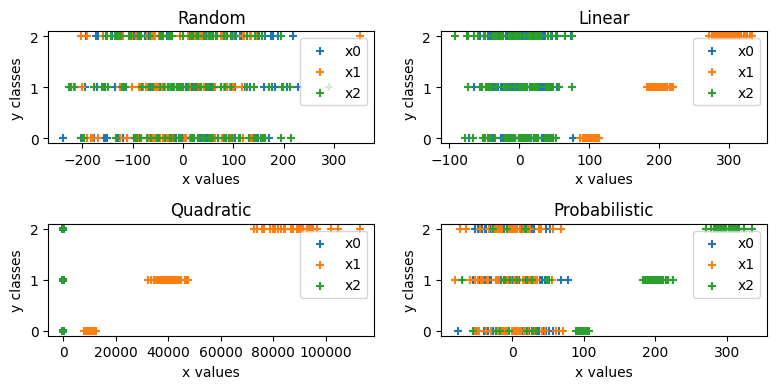

Random 54.0
Linear 1.0
Quadratic 1.0
Probabilistic 20.0


'[1000, 10]  1.0 Time: 1.958\n   [1000, 50]  1.0 Time: 1.753\n   [1000, 100] 1.1 Time: 2.120\n   [1000, 200] 3.9 Time: 2.038\n   [1000, 300] 4.8 Time: 1.959\n   [1000, 400] 9.3 Time: 1.826\n   [1000, 500] 6.4 Time: 2.250\n   [1000, 800] 3.2 Time: 1.812\n'

In [41]:
def get_rand_x(y):
    """No relationship with 'y' whatsoever."""
    lx = 3 # nb of columns
    return np.array([[np.random.normal(0, 100) for i in range(lx)] 
                                               for ry in y])
def get_lin_x(y):
    """Same as 'get_x'."""
    lx = 3                      # nb of columns
    mx = np.random.randint(lx)  # the 'x' that actually impacts 'y'
    return np.array([[np.random.normal(0, 30) if i != mx else 
                      np.random.normal(100, 5)*(ry+1) for i in range(lx)] 
                                                       for ry in y])
def get_qu_x(y):
    """Quadratic relationship."""
    lx = 3                      # nb of columns
    mx = np.random.randint(lx)  # the 'x' that actually impacts 'y'
    return np.array([[np.random.normal(0, 30) if i != mx else 
                      (np.random.normal(100, 5)*(ry+1))**2 
                      for i in range(lx)] for ry in y])
def get_maybe_x(y):
    """Relationship is not absolute."""
    lx = 3                      # nb of columns
    mx = np.random.randint(lx)  # the 'x' that actually impacts 'y'
    p = 0.2                     # probability of failing to impact 'y'
    res = []
    for ry in y:
        res.append([])
        for i in range(lx):
            if i != mx:         # no relationship
                res[-1].append(np.random.normal(0, 30)); continue
            ch = np.random.choice([0, 1], p=[p, 1-p]) # maybe none?
            res[-1].append(np.random.normal(100, 5)*(ry+1)
                           if ch == 1 else np.random.normal(0, 30))
    return np.array(res)

def test_x_noise():
    """Temporary function to test hyperparameter variation, 
       here data noise (relying on 'x' variance)."""
    d = [
        ("Random", gen_dataset(fx=get_rand_x, argx=[])),
        ("Linear", gen_dataset(fx=get_lin_x, argx=[])),
        ("Quadratic", gen_dataset(fx=get_qu_x, argx=[])),
        ("Probabilistic", gen_dataset(fx=get_maybe_x, argx=[]))
    ]
    fig, ax = plt.subplots(2, 2, figsize=(8, 4))
    for i in range(len(d)):
        n, di = d[i]
        j = 1 if i >= 2 else 0
        i = i-2 if i >= 2 else i
        for k in range(len(di[1][0])):
            ax[j, i].scatter(di[1][:,k], di[0], marker="+", label=f"x{k}")
            ax[j, i].set_title(n)
            ax[j, i].set_xlabel("x values")
            ax[j, i].set_ylabel("y classes")
            ax[j, i].legend()
    fig.tight_layout()
    plt.show()
    for i in range(len(d)):
        n, di = d[i]
        k = get_hp(di[0], di[1])
        print(n, np.mean(k))

test_x_noise() # test on 'x' distributions
"""
    Random 19.0               # ~0
    Linear 13.0               # ~0*y
    Quadratic 8.0             # ~0*y^2
    Probabilistic 7.0

    Random 14.0               # ~0
    Linear 2.0                # ~10*y
    Quadratic 13.0            # ~10*y^2
    Probabilistic 26.0

    Random 40.0               # ~0
    Linear 1.0                # ~100*y
    Quadratic 1.0             # ~100*y^2
    Probabilistic 8.0

    Random: 7.1               # ~0
    Linear: 1.0               # ~1000*y
    Quadratic: 1.0            # ~1000*y^2
    Linear-probability: 5.4

    Note: high variance on 'k' mean. 
"""

#test_x_noise() # old test on 'x' variance
"""[1000, 10]  1.0 Time: 1.958
   [1000, 50]  1.0 Time: 1.753
   [1000, 100] 1.1 Time: 2.120
   [1000, 200] 3.9 Time: 2.038
   [1000, 300] 4.8 Time: 1.959
   [1000, 400] 9.3 Time: 1.826
   [1000, 500] 6.4 Time: 2.250
   [1000, 800] 3.2 Time: 1.812
"""